<img src="AW&H2015.tiff" style="float: left">

<img src="flopylogo.png" style="float: center">

# Problem P4.5 Hubbertville Areal Model Perimeter Boundary Conditions

In Problem P4.3 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of pumping.  The town of Hubbertville is planning to expand its water supply by constructing a pumping well in an unconfined gravel aquifer (Fig. P4.3). The well is designed to pump constantly at a rate of 20,000 m3/day. Well construction was halted by the State Fish and Game Service who manage the Green Swamp Conservation area. The agency claimed that pumping would “significantly reduce” groundwater discharge to the swamp and damage waterfowl habitat. The town claimed the fully penetrating river boundary to the north and the groundwater divide located near the center of the valley would prevent any change in flow to the swamp.

Building on P4.3, in Problem P4.5 on page 175 we are asked to replace the constant head boundaries at both the river and swamp in Problem P4.3a with specified flow boundaries. Use the water balance results from Problem P4.3a to calculate the boundary fluxes at the river and swamp. Note that all the boundaries of the model are now specified flow boundaries, including the zero flow lateral boundary conditions.

## Part a.
Run the model with specified flow boundaries using starting heads of 1000 m and then a second time with starting heads of 2000 m. (Note: Some GUIs will warn that using all specified flow boundaries can create errors, or will not
permit the model to execute under these conditions). Compare the results with those in P4.3a and explain the differences.

In this notebook, we will again work through the problem using MODFLOW and the Python tool set Flopy. Notice how much code is reused from P4.1 because the variable names remained the same.

<img src="P4.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds upon the Python Notebook created in Problem P4.3. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial was created by Randy Hunt and all failings are mine.  The exercise here has benefited greatly from the online Flopy tutorial and example notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

## Creating the Model
Using the same steps as in P4.3, we will create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

### Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

### Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P4-5_Hubbertville"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-5_Hubbertville
Creating model working directory.


### Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# In a contrast to P4.1 and P4.2, this is an areal 2D model
LX = 4500.
LY = 11000.   # note that there is an added 500m on the top and bottom to represent the boundary conditions,that leaves an aqufier lenght of 10000 m  
ZTOP = 1030.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 980.
NLAY = 1
NROW = 22
NCOL = 9
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 50.
VKA = 1.
RCH = 0.001
WELLQ = 0.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
print "Pumping well rate =", WELLQ


DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [ 1030.   980.]
Recharge = 0.001
Pumping well rate = 0.0


### Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [4]:
# Assign name and create modflow model object
modelname = 'P4-5'
#exe_name = os.path.join(datapath, 'mfnwt.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mfnwt')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt


### Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [5]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [6]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

### Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [7]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# In this problem we have no specified heads 
print IBOUND

[[[1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1]]]


In [8]:
STRT = 1000 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # P4.5a starting head =1000 m throughout model domain
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  10

In [9]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

### Upstream Weighting Package (like Layer Property Flow Package)
Create a flopy layer property flow package object: [flopy.modflow.ModflowUpw](http://modflowpy.github.io/flopydoc/mfupw.html).

In [10]:
LPF_PACKAGE = flopy.modflow.ModflowUpw(MF, laytyp=1, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

### Well Package
Create a flopy output control object: [flopy.modflow.ModflowWel](http://modflowpy.github.io/flopydoc/mfwel.html).

In [11]:
STRESS_PERIOD_DATA = [
                      [0, 0, 0, -2500],   #layer, row, column, Specified flux Q from P4.3 northern BC
                      [0, 0, 1, -2500],   #remember Python indexing is zero based
                      [0, 0, 2, -2500],
                      [0, 0, 3, -2500],
                      [0, 0, 4, -2500],
                      [0, 0, 5, -2500],
                      [0, 0, 6, -2500],
                      [0, 0, 7, -2500],
                      [0, 0, 8, -2500],
                      [0, 21, 0, -2500],   #layer, row, column, Specified flux Q from P4.3 southern BC
                      [0, 21, 1, -2500],   #remember Python indexing is zero based
                      [0, 21, 2, -2500],
                      [0, 21, 3, -2500],
                      [0, 21, 4, -2500],
                      [0, 21, 5, -2500],
                      [0, 21, 6, -2500],
                      [0, 21, 7, -2500],
                      [0, 21, 8, -2500]]    

WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=STRESS_PERIOD_DATA)  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

### Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [12]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

### Newton-Raphson Solver
Create a flopy pcg package object: [flopy.modflow.ModflowNwt](http://modflowpy.github.io/flopydoc/mfnwt.html).

In [13]:
NWT_PACKAGE = flopy.modflow.ModflowNwt(MF, headtol=0.001, fluxtol=5000, maxiterout=900) 
# print NWT_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

### Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [14]:
#In Problem P4.3 the River and Swamp were specified head BCs. MODFLOW does not include recharge added to a 
#a specified head node in its water budget.  Now that we've changed them to active nodes (IBOUND=1) these would receive 
#recharge, and our model would be out of balance if we simply plugged in the BC fluxes. Try it, you should see that
#perimeter boundary fluxes calculated from P4.3 < recharge specified in P4.5).  Therefore, we'll adjust the recharge
#array so that the perimeter BC nodes are given a recharge rate = 0.

RCH_ARRAY = RCH * np.ones((NROW, NCOL), dtype=np.float32)  # set the variable RCH specifed above for model domain
RCH_ARRAY[0, :] = 0  #don't forget arrays are zero-based!
RCH_ARRAY[-1, :] = 0  #-1 is Python for last in array
print RCH_ARRAY

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.001  

In [15]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH_ARRAY)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

## Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [16]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-5_Hubbertville
[]


In [17]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [18]:
#Now write the model input files
MF.write_input()

Yup.  It's that simple, the model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [19]:
# return current working directory
print "You can check the newly created files in", modelpath


You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-5_Hubbertville


## Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [20]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:34

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:34
 Elapsed run time:  0.013 Seconds

  Normal termination of simulation


## Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [21]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-5.hds) contains the following list of times:  [1.0]


In [22]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  989.465
  max:  1004.6
  std:  4.77231


Contour Levels:  [  989.    989.5   990.    990.5   991.    991.5   992.    992.5   993.
   993.5   994.    994.5   995.    995.5   996.    996.5   997.    997.5
   998.    998.5   999.    999.5  1000.   1000.5  1001.   1001.5  1002.
  1002.5  1003.   1003.5  1004.   1004.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


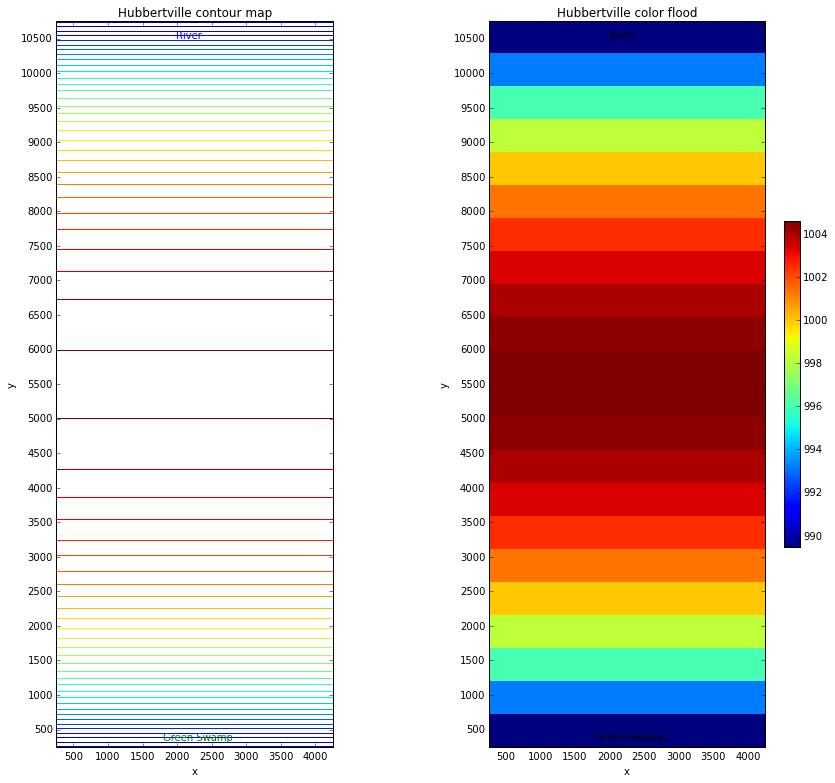

In [23]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(989., 1005., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


Look at the bottom of the MODFLOW output file (ending with a *.list) and note the water balance reported. 

In [24]:
#look at the head in column = 4 from headobj, and then plot it
#print HEAD along a column; COL is a variable that allows us to change this easily
COL = 4
print HEAD[0,:,COL]

[  989.46466064   993.24084473   996.04541016   998.23858643   999.98950195
  1001.39190674  1002.50286865  1003.35906982  1003.98449707  1004.39440918
  1004.59771729  1004.59771729  1004.39440918  1003.98449707  1003.35906982
  1002.50286865  1001.39190674   999.98950195   998.23858643   996.04541016
   993.24084473   989.46466064]


In [25]:
# we see this is what we want, but is flipped because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[  989.46466064   993.24084473   996.04541016   998.23858643   999.98950195
  1001.39190674  1002.50286865  1003.35906982  1003.98449707  1004.39440918
  1004.59771729  1004.59771729  1004.39440918  1003.98449707  1003.35906982
  1002.50286865  1001.39190674   999.98950195   998.23858643   996.04541016
   993.24084473   989.46466064]


In [26]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


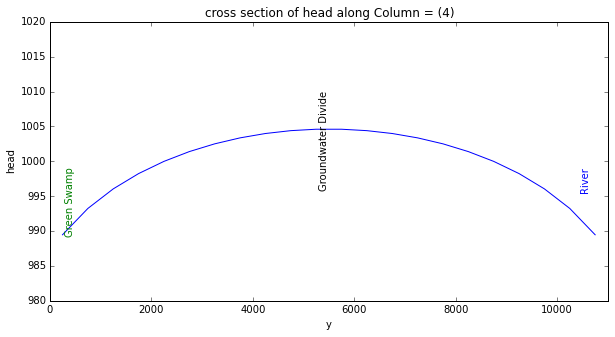

In [27]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5300,1009., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

## Now Change Starting Heads to 2000 m


In [28]:
#in order to keep the problem unconfined we'll have to raise the top above what was set in P4.3 (=1030 m)
ZTOP = 2030.

In [29]:
STRT = 2000 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # P4.5a starting head=2000 m throughout model domain
print STRT

[[[ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.]
  [ 2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  20

In [30]:
#we have to update the MODFLOW's BAS Package with the new IBOUND array 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [31]:
#in order to keep the problem unconfined we'll have to raise the top above what was set in P4.3 (=1030 m)
TOP = 2030.

#in order to keep the same transmissivity we need to raise the base so the resulting saturated thickness is the same
BOT = 1980.

In [32]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOT, laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [33]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-5.bas
Deleted:  P4-5.cbc
Deleted:  P4-5.ddn
Deleted:  P4-5.dis
Deleted:  P4-5.hds
Deleted:  P4-5.list
Deleted:  P4-5.nam
Deleted:  P4-5.nwt
Deleted:  P4-5.oc
Deleted:  P4-5.rch
Deleted:  P4-5.upw
Deleted:  P4-5.wel


In [34]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-5.bas', 'P4-5.cbc', 'P4-5.ddn', 'P4-5.dis', 'P4-5.hds', 'P4-5.list', 'P4-5.nam', 'P4-5.nwt', 'P4-5.oc', 'P4-5.rch', 'P4-5.upw', 'P4-5.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-5_Hubbertville


In [35]:
#rerun MODFLOW-NWT
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:35

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:35
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


In [36]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-5.hds) contains the following list of times:  [1.0]
Head statistics
  min:  1989.46
  max:  2004.6
  std:  4.77233


Contour Levels:  [ 1989.   1989.5  1990.   1990.5  1991.   1991.5  1992.   1992.5  1993.
  1993.5  1994.   1994.5  1995.   1995.5  1996.   1996.5  1997.   1997.5
  1998.   1998.5  1999.   1999.5  2000.   2000.5  2001.   2001.5  2002.
  2002.5  2003.   2003.5  2004.   2004.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


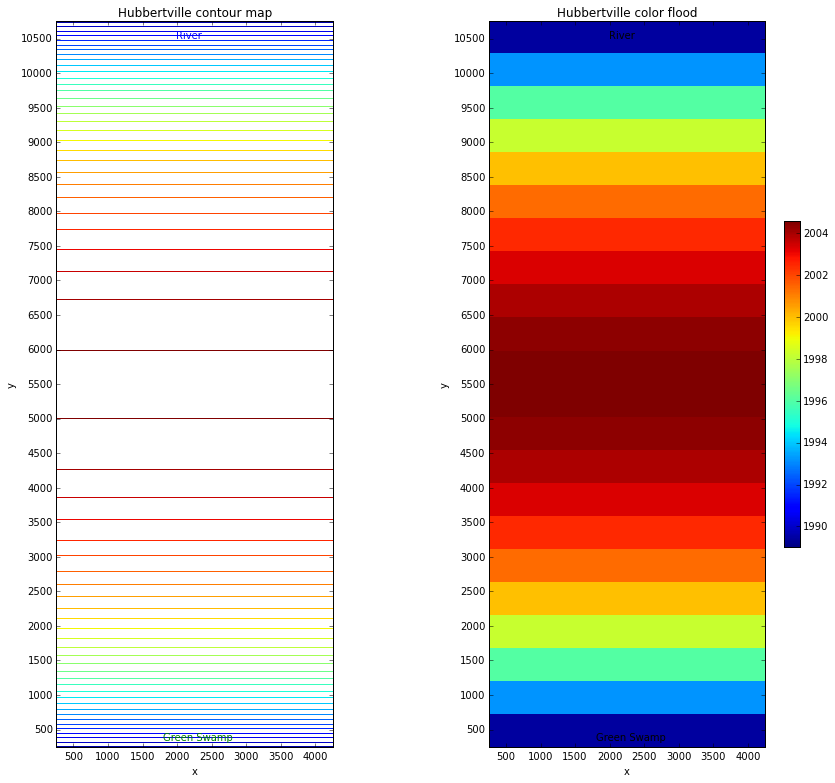

In [37]:
#-999.99 is the Inactive node flag so we'll use our previous contour settings
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1989., 2005., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=1989)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

In [38]:
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[ 1989.46459961  1993.24084473  1996.04541016  1998.23852539  1999.98950195
  2001.39196777  2002.50292969  2003.35913086  2003.98449707  2004.39440918
  2004.59765625  2004.59765625  2004.39440918  2003.98449707  2003.35913086
  2002.50292969  2001.39196777  1999.98950195  1998.23852539  1996.04541016
  1993.24084473  1989.46459961]


In [39]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


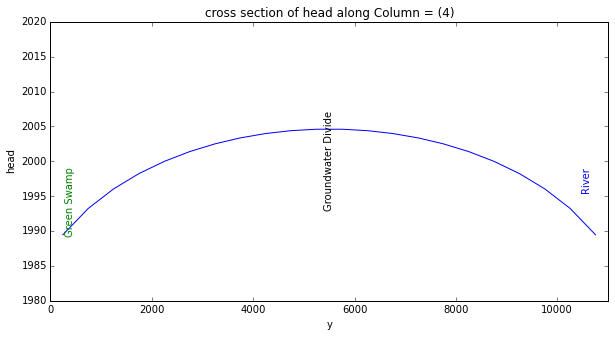

In [40]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(1980.,2020.)
ax.text(10480, 1998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 1998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,2006., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

How do the two versions of starting head compare?  What does this conceptualization need to keep this problem from being a relative result?

## Part b. 

Take one of the models you designed in part (a) and replace one constant flux node on either the river or swamp boundary with a specified head node equal to 1000 m. Run the model to steady state. Compare the results with those in
part (a) and with P4.3a. Explain the differences.


In [41]:
# let's use the first model of Part a so that the starting head of 1000 m is not below the bottom of the aquifer 
TOP = 1030.
BOT = 980.

#we'll set the cell in the first row and first column to a specified head (changing it's IBOUND value to -1)
IBOUND[:, 0, 0] = -1 
print IBOUND

[[[-1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]]]


In [42]:
#change the starting head to equal 1000 m
STRT = 1000 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  10

In [43]:
#we have to update MODFLOW's BAS Package with the new IBOUND and STRT heads 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [44]:
print 'aquifer top =', TOP
print 'aquifer bottom =', BOT
#we have to update MODFLOW's DIS Package for the new tops and bottoms 
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOT, laycbd=0)

aquifer top = 1030.0
aquifer bottom = 980.0
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [45]:
#delete old files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-5.bas
Deleted:  P4-5.cbc
Deleted:  P4-5.ddn
Deleted:  P4-5.dis
Deleted:  P4-5.hds
Deleted:  P4-5.list
Deleted:  P4-5.nam
Deleted:  P4-5.nwt
Deleted:  P4-5.oc
Deleted:  P4-5.rch
Deleted:  P4-5.upw
Deleted:  P4-5.wel


In [46]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-5.bas', 'P4-5.cbc', 'P4-5.ddn', 'P4-5.dis', 'P4-5.hds', 'P4-5.list', 'P4-5.nam', 'P4-5.nwt', 'P4-5.oc', 'P4-5.rch', 'P4-5.upw', 'P4-5.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-5_Hubbertville


In [47]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:37

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:15:37
 Elapsed run time:  0.006 Seconds

  Normal termination of simulation


In [48]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-5.hds) contains the following list of times:  [1.0]
Head statistics
  min:  1000.0
  max:  1010.57
  std:  3.39633


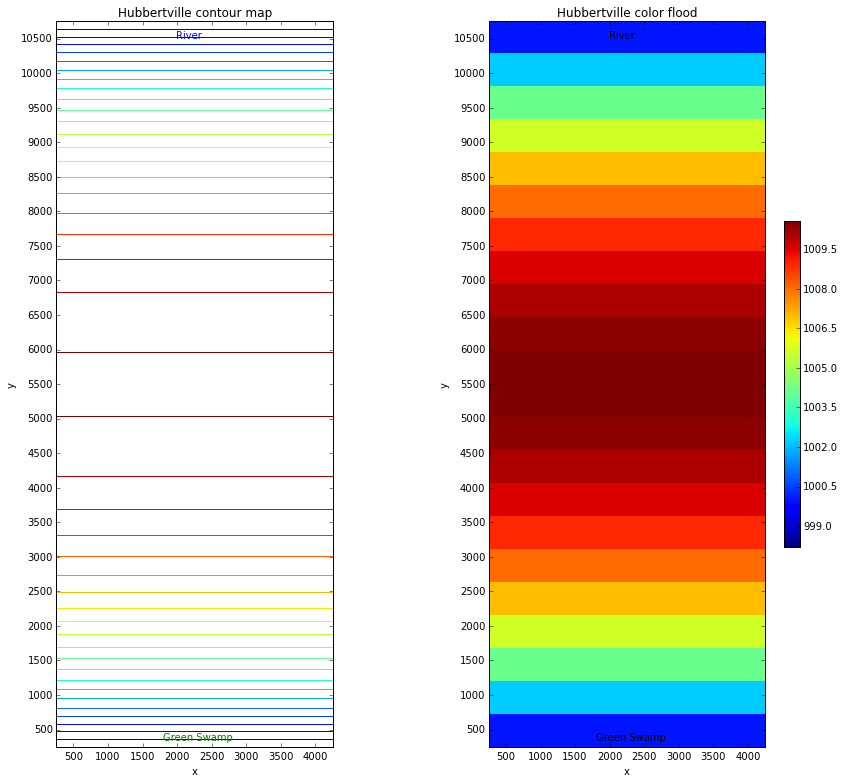

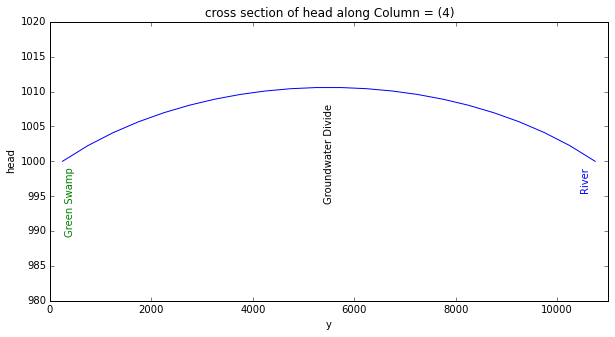

In [49]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

1.) Compare the results with those in P4.5 Part (a) and with P4.3a. What can we conclude?

2.) Rerun the second part of problem P4.5b with the original base elevation (= 980 m) in step In [31].  Leave the top elevation at the new value (=2030 m). Why are the gradients different? 